In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow.compat.v2.feature_column as fc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

# string = tf.Variable('hola', tf.string)
# print(string)

dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')


y_train = dftrain.pop('survived') #se separan las columnas que dicen si sobrevivió o no el pasajero
y_eval = dfeval.pop('survived')

#se separan los nombres de las columnas en funcion del tipo de dato que contienen
col_cat = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
col_num = ['age', 'fare']

feature_columns=[]

for feature in col_cat:
    vocab = dftrain[feature].unique() #lista de los distintos valores que adoptan los datos en la columna
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature, vocab))
    
for feature in col_num:
    feature_columns.append(tf.feature_column.numeric_column(feature, dtype=tf.float32))
    
feature_columns #es una lista de "tensores


[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.strin

In [2]:
#dftrain.age.hist(bins=30)

In [3]:
#dftrain.sex.value_counts()

In [4]:
#dftrain['class'].value_counts()#.plot(kind='barh')

Text(0, 0.5, '%survived')

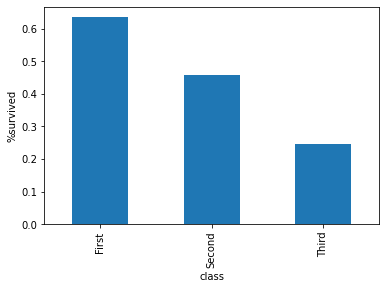

In [72]:
pd.concat([dftrain, y_train], axis=1).groupby('class').survived.mean().plot(kind='bar').set_ylabel('%survived')

In [6]:
# pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='bar').set_ylabel('%survived')
# new= pd.concat([dftrain, y_train], axis=1).groupby('sex').mean()
# new

In [61]:
def make_input_fn(data_df, label_df, num_epochs=300, shuffle=True, batch_size=100):
    def input_function(): #funcion interna que será el resultado de la primer función 
        ds= tf.data.Dataset.from_tensor_slices((dict(data_df),label_df)) #crea un objeto de la calse tf a partir del dataframe original (pd)
        if shuffle:
            ds=ds.shuffle(1000) #randomiza el orden de los datos
        ds=ds.batch(batch_size).repeat(num_epochs) #divide los datos en grupos o batchs de a 32, muchas veces (num_epochs veces)
        return ds #devuelve el batch de datos del dataframe
    return input_function #devuelve la funcion a utilizar

train_input_fn= make_input_fn(dftrain, y_train)
eval_input_fn= make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False) # no necesitamos suffle porque esto no es un entrenamiento


linear_est= tf.estimator.LinearClassifier(feature_columns=feature_columns)

linear_est.train(train_input_fn) #entrenamiento
result= linear_est.evaluate (eval_input_fn) #obtiene metricas y estadisticas del modelo evaluandolo con "testing data"

clear_output()
print(result['accuracy'])


0.7878788


In [62]:
result2 = list(linear_est.predict(eval_input_fn))

# x= 1 #indice del individuo a evaluar

# print(dfeval.loc[x])

# print(str(round((float(result2[x]['probabilities'][1])*100),2)) + '%') #probabilidad de sobrevivir de cada individuo de la lista (primer corchete)

# if y_eval[x]==1: #esto evalua si efectivametne el individuo sobrevivio segun los datos
#     print ('Survived')
# else:
#     print ('Did not Survived')


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\msaba\AppData\Local\Temp\tmpcz6b9d8h\model.ckpt-2100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [69]:
x= 1 #indice del individuo a evaluar

print(dfeval.loc[x])

print(str(round(float(result2[x]['probabilities'][1]*100),2)) + '%') #probabilidad de sobrevivir de cada individuo de la lista (primer corchete)

if y_eval[x]==1: #esto evalua si efectivametne el individuo sobrevivio segun los datos
    print ('Survived')
else:
    print ('Did not Survived')

sex                          male
age                          54.0
n_siblings_spouses              0
parch                           0
fare                      51.8625
class                       First
deck                            E
embark_town           Southampton
alone                           y
Name: 1, dtype: object
47.04%
Did not Survived


evaluación casera de la exactitud del modelo, comparar result2[x]['probabilities'][1] con y_eval[x]

In [63]:
x=0
y=200 #numero de individuos a evaluar:
probabilidad=0.8 #probabilidad considerada umbral para ver supervivencia
aciertos=0

while x<y:
    if result2[x]['probabilities'][1]>probabilidad and y_eval[x]==1:
        aciertos+=1
        
    elif result2[x]['probabilities'][1]<probabilidad and y_eval[x]==0:
        aciertos+=1
    x+=1

print ('el modelo predice correctamente {} de {} predicciones'.format(aciertos, y))
print ('el porcentaje de aciertos es {:.2f}'.format(aciertos/y))
print ('accuracy del modelo es {:.2f}'.format(result['accuracy']))

#esto da 149 de 200 (aprox 75%), es lo mismo que el accuracy del modelo
#datos, total pasajeros titanic=2223, total sobrevivientes=705, % muertes= 68%... muertes por clase= 75% (3), 59%(2), 38% (1)

el modelo predice correctamente 154 de 200 predicciones
el porcentaje de aciertos es 0.77
accuracy del modelo es 0.79


[0.063622475, 0.47038382, 0.72286695, 0.5736653, 0.22737265, 0.7875071, 0.36278978, 0.106436364, 0.660223, 0.75931674, 0.6872952, 0.10633618, 0.93465227, 0.45972174, 0.87432116, 0.47023368, 0.13419726, 0.8578306, 0.115250014, 0.07955125, 0.110229716, 0.12279749, 0.70467335, 0.056786273, 0.7139483, 0.5910904, 0.18759196, 0.30274913, 0.21140009, 0.8967599, 0.10262408, 0.79855067, 0.18066145, 0.68560284, 0.32628998, 0.085541226, 0.18553507, 0.10033117, 0.92869586, 0.07666418, 0.71038365, 0.14448924, 0.22298503, 0.35202834, 0.16173358, 0.89401835, 0.10638627, 0.3118415, 0.5658046, 0.49287868, 0.098511964, 0.2190382, 0.04671454, 0.0646179, 0.11843087, 0.09516144, 0.15285711, 0.97156966, 0.16909291, 0.08248812, 0.2738613, 0.5618449, 0.18507843, 0.88494074, 0.15672427, 0.67035353, 0.5589582, 0.06759612, 0.09968976, 0.69791514, 0.94375247, 0.6282883, 0.024241317, 0.114307985, 0.10292209, 0.07709796, 0.102622546, 0.10033117, 0.73654664, 0.9762772, 0.68013996, 0.45972174, 0.14303908, 0.98271275,

(array([ 1.,  1.,  3.,  6.,  4.,  9., 11., 18., 15., 15.,  6., 15.,  3.,
         3.,  5.,  4.,  1.,  4.,  2.,  2.,  1.,  5.,  0.,  1.,  0.,  0.,
         1.,  1.,  1.,  1.,  2.,  2.,  2.,  0.,  2.,  1.,  2.,  0.,  0.,
         2.,  1.,  0.,  2.,  0.,  0.,  3.,  2.,  1.,  1.,  1.,  0.,  1.,
         1.,  0.,  0.,  1.,  4.,  1.,  0.,  1.,  1.,  1.,  2.,  3.,  1.,
         0.,  2.,  4.,  1.,  8.,  4.,  5.,  3.,  2.,  3.,  2.,  1.,  3.,
         0.,  2.,  2.,  2.,  3.,  0.,  1.,  3.,  2.,  0.,  3.,  2.,  2.,
         4.,  0.,  1.,  4.,  2.,  2.,  1.,  6.,  4.]),
 array([0.01400743, 0.02372761, 0.0334478 , 0.04316799, 0.05288818,
        0.06260836, 0.07232855, 0.08204874, 0.09176893, 0.10148911,
        0.1112093 , 0.12092949, 0.13064967, 0.14036986, 0.15009005,
        0.15981025, 0.16953042, 0.17925061, 0.1889708 , 0.19869098,
        0.20841117, 0.21813136, 0.22785155, 0.23757173, 0.24729192,
        0.2570121 , 0.2667323 , 0.27645248, 0.2861727 , 0.29589286,
        0.30561304, 0.3153

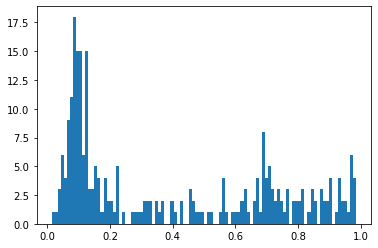

In [71]:
probabilidades=[]
for i in range(len(result2)):
    probabilidades.append(result2[i]['probabilities'][1])
    
print (probabilidades)

plt.hist(probabilidades, 100)